## Load libraries

Kernel dies if I execute the following:

import os
import sys
hashseed = os.getenv('PYTHONHASHSEED')
if not hashseed:
    os.environ['PYTHONHASHSEED'] = '0'
    os.execv(sys.executable, [sys.executable] + sys.argv)

In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1326 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [4]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

In [5]:
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)

print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.947
Zero inflation of aggregated data: 0.856


## Filter cells

Filter based on median absolute standard deviation:

- log1p_total_counts: count depth (number of counts per barcode)
- log1p_n_genes_by_counts: number of detected genes by barcode

Filter genes based on:
- min_cells = 2: at least gene is expressed in 2 cells

Further, filter cells based on:
- min_genes: at least 2 genes have to be expressed

In [6]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    1255
True       71
Name: outlier, dtype: int64
Total number of cells: 1326
Number of cells after filtering: 1255


AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

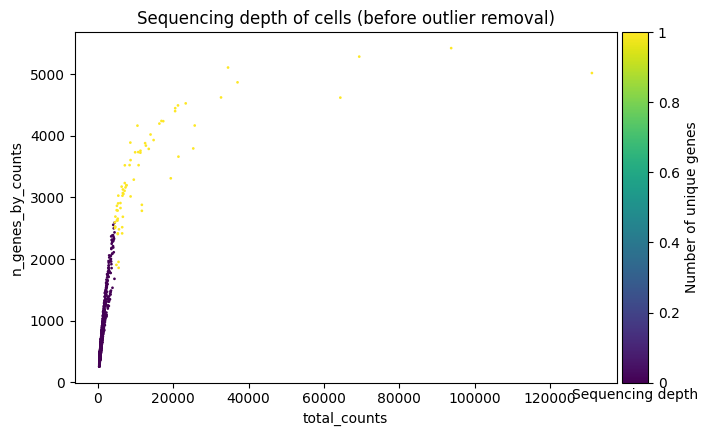

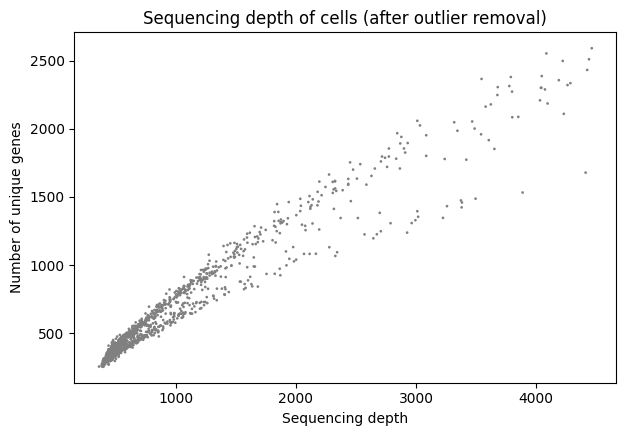

In [7]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [8]:
data_gene.layers["counts"] = data_gene.X.copy()

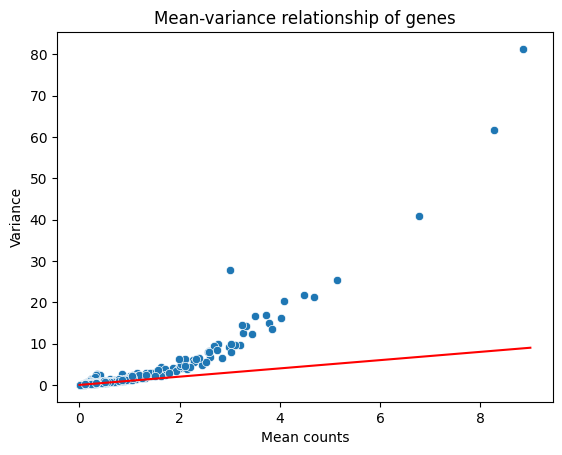

In [9]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [10]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="BFGS")
data_gene.var["nb_overdisp_cutoff_bfgs"] = data_gene.var["nb_overdisp_cutoff"]
data_gene.var["nb_overdisp_bfgs"] = data_gene.var["nb_overdisp"]


Fitting feature 100/5540
Fitting feature 200/5540
Fitting feature 300/5540
Fitting feature 400/5540
Fitting feature 500/5540
Fitting feature 600/5540
Fitting feature 700/5540
Fitting feature 800/5540
Fitting feature 900/5540
Fitting feature 1000/5540
Fitting feature 1100/5540
Fitting feature 1200/5540
Fitting feature 1300/5540
Fitting feature 1400/5540
Fitting feature 1500/5540
Fitting feature 1600/5540
Fitting feature 1700/5540
Fitting feature 1800/5540
Fitting feature 1900/5540
Fitting feature 2000/5540
Fitting feature 2100/5540
Fitting feature 2200/5540
Fitting feature 2300/5540
Fitting feature 2400/5540
Fitting feature 2500/5540
Fitting feature 2600/5540
Fitting feature 2700/5540
Fitting feature 2800/5540
Fitting feature 2900/5540
Fitting feature 3000/5540
Fitting feature 3100/5540
Fitting feature 3200/5540
Fitting feature 3300/5540
Fitting feature 3400/5540
Fitting feature 3500/5540
Fitting feature 3600/5540
Fitting feature 3700/5540
Fitting feature 3800/5540
Fitting feature 3900/

<Axes: xlabel='nb_mean', ylabel='Count'>

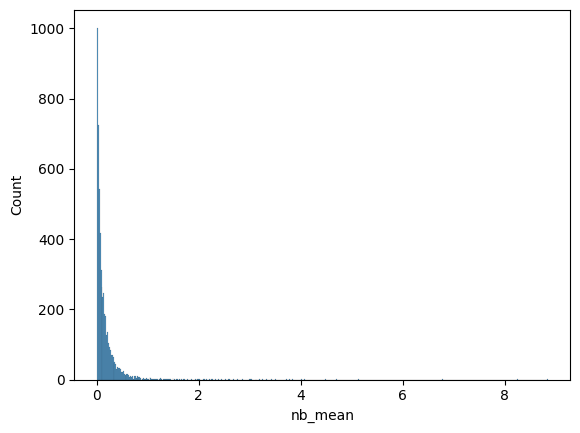

In [11]:
sns.histplot(data_gene.var["nb_mean"])

In [12]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")

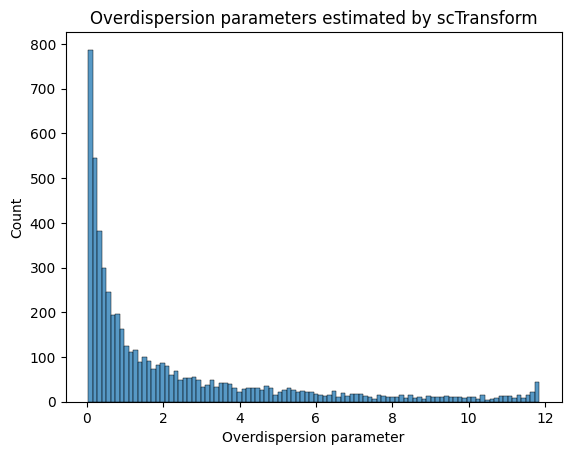

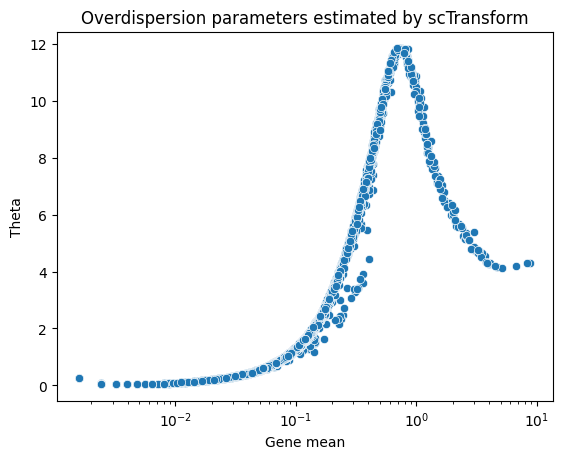

In [13]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

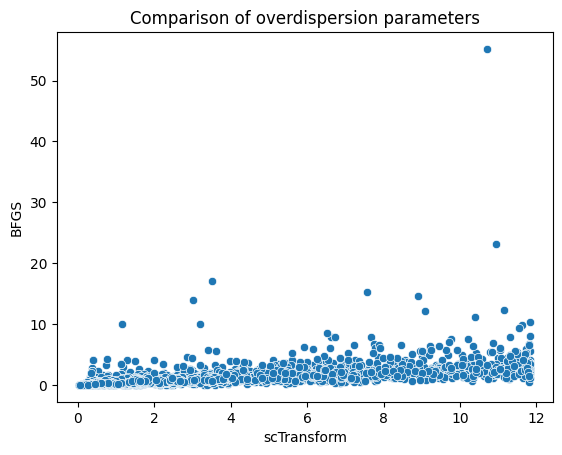

Correlation: [[1.         0.62859382]
 [0.62859382 1.        ]]


In [14]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff_bfgs", x="nb_overdisp_cutoff")
plt.title("Comparison of overdispersion parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

print(f"Correlation: {np.corrcoef(data_gene.var['nb_overdisp_cutoff_bfgs'], data_gene.var['nb_overdisp_cutoff'])}")

In [15]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [16]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)

# Only normalization
data_gene.layers["normalized_counts"] = data_gene.X.copy()

# Variance Stabilization Transformation
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()

#min_vst_counts = data_gene.layers["vst_counts"].min()

# Scale data to unit variance and zero mean. Truncate values to 10
#sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0

# Apply full PCA
sc.tl.pca(data_gene, svd_solver='arpack')

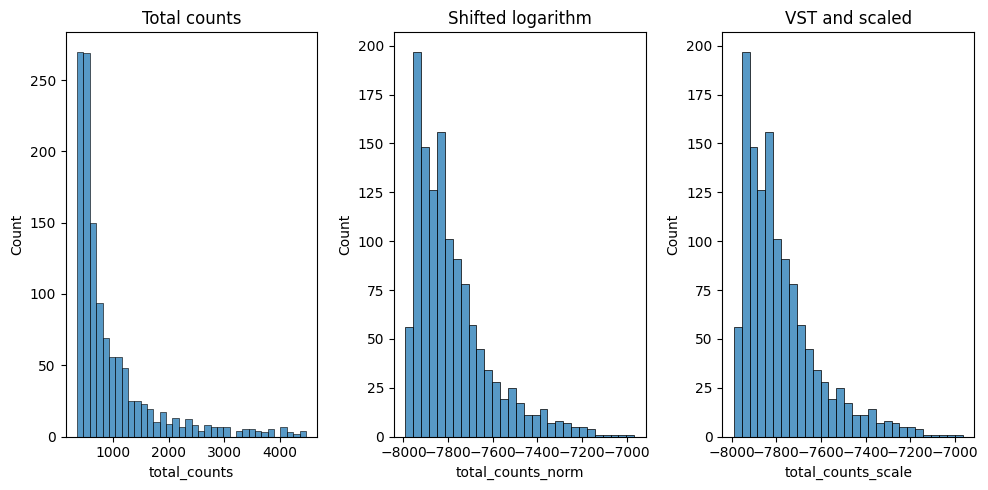

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [18]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1255 × 5424
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    layers: 'counts'


Transformation of train and test data

In [26]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=None, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()

# Variance Stabilization Transformation
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
data_train.layers["vst_counts_shifted"] = data_train.layers["vst_counts"].copy().todense() + data_train.layers["vst_counts"].min() * -1.

# test data
sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.layers["normalized_counts"] = data_test.X.copy()
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
data_test.layers["vst_counts_shifted"] = data_test.layers["vst_counts"].copy().todense() + data_test.layers["vst_counts"].min() * -1.

## Parameter search: NMD

In [41]:
importlib.reload(cs)

<module 'tools.countsplit' from '/Users/stffn/projects/thesis_dev/BacSC/tools/countsplit.py'>

In [42]:
data_layer = "normalized_counts"

In [43]:
ks_2_check = [15, 12, 10, 8, 7, 6, 5, 4, 3, 2, 1]
betas_2_check = [0.6, 0.7, 0.8, 0.9, 0.95]

In [44]:
select_cs_results = cs.select_nmd_t_params_countsplit(data_train, data_test, potential_ks=ks_2_check, potential_betas=betas_2_check, layer=data_layer)

################## LATENT DIM 15
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 12
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 10
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 8
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 7
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 6
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################

In [45]:
select_cs_results

,k,beta,loss
0,15,0.60,574.833251
1,15,0.70,577.685368
2,15,0.80,578.063055
3,15,0.90,579.314342
4,15,0.95,605.613403
5,12,0.60,567.528655
6,12,0.70,569.979049
7,12,0.80,570.333894
8,12,0.90,570.873427
9,12,0.95,698.376000


<Axes: xlabel='k', ylabel='loss'>

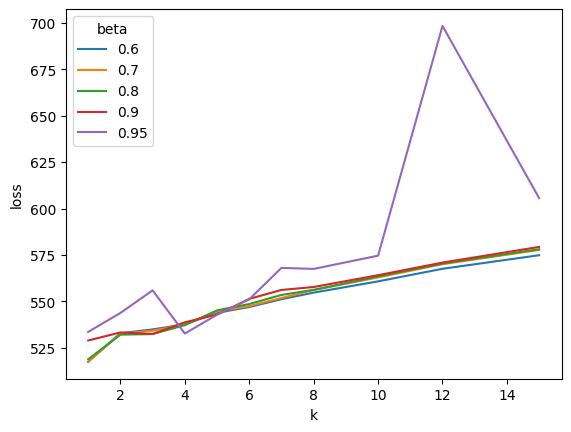

In [52]:
sns.lineplot(data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10")

In [46]:
select_cs_3b_results = cs.select_3b_params_countsplit(data_train, data_test, potential_ks=ks_2_check, potential_betas=betas_2_check, layer=data_layer)

################## LATENT DIM 15
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 12
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 10
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 8
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 7
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 6
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################

In [47]:
select_cs_3b_results

,k,beta,loss
0,15,0.60,575.837275
1,15,0.70,576.245036
2,15,0.80,575.026868
3,15,0.90,573.874661
4,15,0.95,561.569960
5,12,0.60,568.264117
6,12,0.70,568.516727
7,12,0.80,566.071568
8,12,0.90,564.705296
9,12,0.95,553.090948


<Axes: xlabel='k', ylabel='loss'>

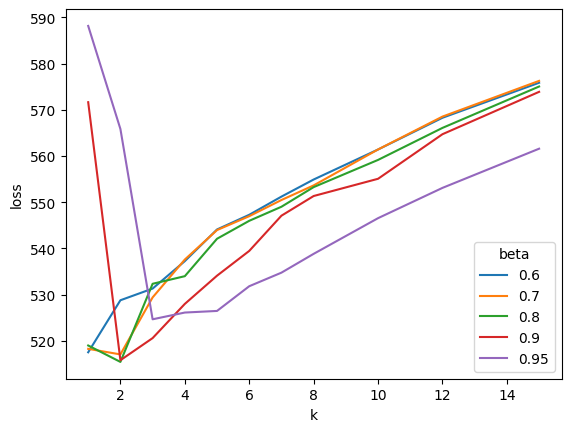

In [51]:
sns.lineplot(data=select_cs_3b_results, x="k", y="loss", hue="beta", palette="tab10")

In [54]:
select_cs_3b_results["algorithm"] = "3B-NMD"
select_cs_results["algorithm"] = "NMD-T"

cs_param_search = pd.concat([select_cs_3b_results, select_cs_results], axis=0)
cs_param_search.head()

,k,beta,loss,algorithm
0,15,0.60,575.837275,3B-NMD
1,15,0.70,576.245036,3B-NMD
2,15,0.80,575.026868,3B-NMD
3,15,0.90,573.874661,3B-NMD
4,15,0.95,561.569960,3B-NMD


In [59]:
# https://stackoverflow.com/questions/76404811/attributeerror-dataframe-object-has-no-attribute-iteritems
pd.DataFrame.iteritems = pd.DataFrame.items 

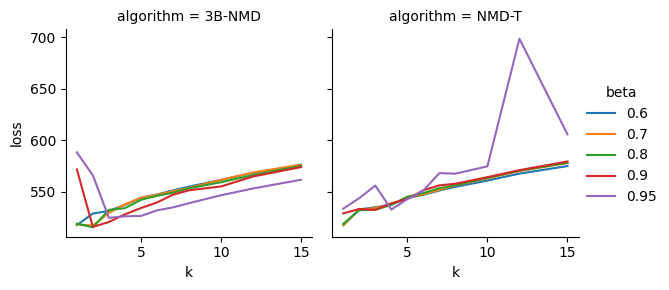

In [62]:
g = sns.FacetGrid(data=cs_param_search, col="algorithm", hue="beta", palette="tab10")
g.map(sns.lineplot, "k", "loss")
g.add_legend()
plt.show()

## NMD 3-B

In [20]:
from tools import NMD as nmd

In [23]:
k_opt = 2
beta_opt = 0.8
data_layer = "normalized_counts"

In [24]:
m, n = data_gene.X.shape
X_nmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_nmd.shape
W0, H0 = cs.nuclear_norm_init(X_nmd, m, n, k_opt)
Theta0 = W0 @ H0

In [26]:
Theta_3b, W_3b, H_3b, loss_3b, iters_3b, times_3b = nmd.nmd_3b(X_nmd, r=k_opt, W0=W0, H0=H0, beta1=beta_opt, tol_over_10iters=1e-5)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 74.713342] - 0.284810 secs
[1 : 74.338774] - 0.551294 secs
[2 : 74.162861] - 0.219493 secs
[3 : 74.540673] - 0.221385 secs
[4 : 74.987103] - 0.224981 secs
[5 : 74.776201] - 0.219828 secs
[6 : 74.378757] - 0.221089 secs
[7 : 73.800300] - 0.224878 secs
[8 : 73.499982] - 0.222786 secs
[9 : 73.459705] - 0.219830 secs
[10 : 73.432648] - 0.221446 secs
[11 : 73.402659] - 0.222073 secs
[12 : 73.401092] - 0.224382 secs
[13 : 73.365140] - 0.222857 secs
[14 : 73.316082] - 0.224966 secs
[15 : 73.319128] - 0.226111 secs
[16 : 73.304175] - 0.222825 secs
[17 : 73.294415] - 0.234093 secs
[18 : 73.303643] - 0.235987 secs
[19 : 73.290564] - 0.234506 secs
[20 : 73.279855] - 0.224582 secs
[21 : 73.293588] - 0.276594 secs
[22 : 73.283673] - 0.341474 secs
[23 : 73.278292] - 0.238523 secs
[24 : 73.290639] - 0.218948 secs
[25 : 73.284907] - 0.218986 secs
[26 : 73.277569] - 0.222453 secs
[27 : 73.288403] - 0.221037 

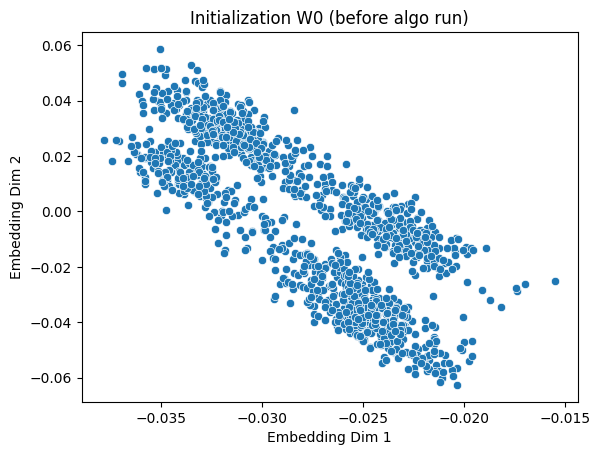

In [27]:
sns.scatterplot(W0[:,0], W0[:,1]).set(title="Initialization W0 (before algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

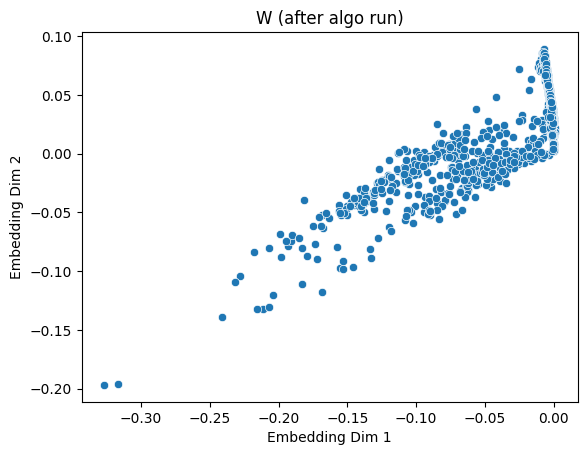

In [28]:
sns.scatterplot(W_3b[:,0], W_3b[:,1]).set(title="W (after algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

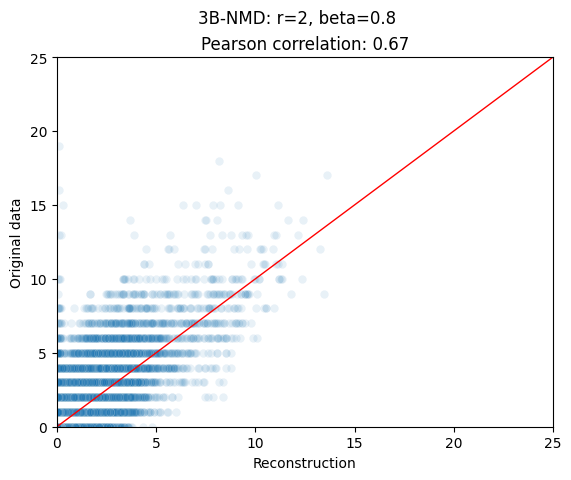

In [46]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b), X_nmd, "3B-NMD: r=2, beta=0.8", type="scatter", sample_fraction=0.2)

## NMD-T